# Transforming GPS Tracks to Line Segments

For the past 6 months or so, I have been collecting GPS data via Runkeeper of my bike rides. I'm a bike commuter so most of my rides follow the same path, but I'm still interested in exploring my data. In this post I outline how I took GPS track points from Runkeeper and transformed each consecutive pair into individual line segments in a new dataset using **geopandas** and **shapely**.

## Exploring Runkeeper Data
A few weeks ago, I downloaded each individual `gpx` data file of my rides and picked a random trip to explore. If you've ever dealt with `gpx` data, you might have noticed that it comes with several different layers. I'll be using a test set of my GPS data called `gps_test_data.gpx` throughout this post. Before we go much further, let's use **fiona** to take a peak inside this `gpx` file.

In [47]:
import fiona

fname = 'gps_test_data.gpx'
fiona.listlayers(fname)

['waypoints', 'routes', 'tracks', 'route_points', 'track_points']

So this `gpx` data actually appears to consist of 5 layers. In my case the layers Runkeeper collects data for are a `tracks` - a single line feature comprising the entire path you traveled - and `track_points` - regularly collected x/y cooridinates with elevation and a time stamp. I wanted to create a linear representation of my data to show changes in speed and elevation along the route. My first step was to check out the `tracks` layer and see if it contained the data I'd need to do some interesting exploration. 

# of features:
--------------
 1
Feature attribute data:
-----------------------
 OrderedDict([('name', 'Cycling 12/29/17 4:42 pm'), ('cmt', None), ('desc', None), ('src', None), ('link1_href', None), ('link1_text', None), ('link1_type', None), ('link2_href', None), ('link2_text', None), ('link2_type', None), ('number', None), ('type', None)])


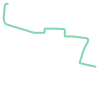

In [73]:
# Open tracks layer
tracks_layer = fiona.open(fname, layer='tracks')
feature = tracks_layer[0]
properties = feature['properties']

print("# of features:\n--------------\n", len(list(tracks_layer.items())))
print("Feature attribute data:\n-----------------------\n", properties)

from shapely.geometry import shape

tracks_data = {'type': 'MultiLineString',
               'coordinates': feature['geometry']['coordinates']}
tracks_shp = shape(tracks_data)
tracks_shp

Although the `tracks` layer is good at showing the path traveled, there are no time stamps or elevation values in for start, finish or anywhere in between. It's going to be tough to do much else with this layer besides draw it on a map.

On to `track_points`. What does it have to offer us? Let's see how many features are in that layer and peak at the first feature to find out what data was collected for each feature.

In [78]:
track_pts_layer = fiona.open(fname, layer='track_points')
feature = track_pts_layer[0]
properties = feature['properties']

print("# of features:\n--------------\n", len(list(track_pts_layer.items())))
print("Feature attribute data:\n-----------------------\n", properties)

# of features:
--------------
 163
Feature attribute data:
-----------------------
 OrderedDict([('track_fid', 0), ('track_seg_id', 0), ('track_seg_point_id', 0), ('ele', 125.7), ('time', '2017-12-29T21:42:18'), ('magvar', None), ('geoidheight', None), ('name', None), ('cmt', None), ('desc', None), ('src', None), ('link1_href', None), ('link1_text', None), ('link1_type', None), ('link2_href', None), ('link2_text', None), ('link2_type', None), ('sym', None), ('type', None), ('fix', None), ('sat', None), ('hdop', None), ('vdop', None), ('pdop', None), ('ageofdgpsdata', None), ('dgpsid', None)])


There are 163 features in `track_points`. This is promising though not altogether a sign that this data is useful. Indeed, the geometry for `track_points` could be generated from `tracks` itself. What we really need is some sort of timestamp for each point and an elevation value. Looking at the feature attribute data for the first point in `track_points` it looks like we have that in `'time'` and `'ele'`, respectively. There's also a helpful value, `'track_seg_point_id'` which helps track the order in which each feature was collected.

## What to do?

`track_points` contains snapshots of data - time, elevation, sequence id, and location information - as collected at each point along my journey. It would perhaps be more interesting to examine things like change in elevation or speed throughout my ride. What if could calculate the difference in elevation, travel time, and distance between consecutive points We can use the consecutive points? And what if, since we're calculating these differences over consecutive points, we could represent each consecutive point as an individual line segment? The answer is, we can! For the rest of this post, I'm going to walk through how I went about constructing line segments between consecutive points in `track_points` and calculating change in elevation, change in distance, change in time, and speed using geopandas and shapely.

## Setting up

First we need to load some libraries. We've alread loaded fiona, but we'll need some other libraries to help:

In [80]:
# May not be necessary, but it could be useful in case there's a need to plot
%matplotlib inline 
import pandas as pd # For working with DataFrames
import geopandas as gpd # For working with spatial data and DataFrames
from geopandas import GeoDataFrame # For creating GeoDataFrames
from shapely.geometry import LineString # For creating LineString features
import folium # For creating a map of the data

## Load `track_points`

We need to load `track_points` into a special type of DataFrame called a *GeoDataFrame*. This will allow us to carry out spatial operations on `track_points` while also being able to use pandas for data manipulation. Earlier we defined our datafile, `gps_test_data.gpx`, as `fname`. To load `track_points` into a GeoDataFrame, `gdf`, we pass `fname` to `gpd.read_file()`. Because our `gpx` file has several layers, we specify the `layer` as `track_points`. Sort `gdf` on `track_seg_point_id` to ensure that the rows of the GeoDataFrame are in the correct order. Reset the index to ensure that the index increments by 1s starting at 0.

If you recall from earlier when we first examined `track_points` there were several fields for which either the data were not meaningful or no data was collected. To make our `gdf` a bit easier to deal with, we'll limit te columns to just the `track_seg_id`, `ele`, `time`, and `geometry`.

In [113]:
gdf = gpd.read_file(fname, layer = 'track_points')
gdf.sort_values('track_seg_point_id', inplace=True)
gdf.reset_index(drop=True, inplace=True)
gdf = gdf[['track_seg_point_id', 'ele', 'time', 'geometry']].copy()
gdf.head()

,track_seg_point_id,ele,time,geometry
0,0,125.7,2017-12-29T21:42:18,POINT (-78.668663 35.787979)
1,1,125.6,2017-12-29T21:42:23,POINT (-78.668841 35.787985)
2,2,125.4,2017-12-29T21:42:25,POINT (-78.66897 35.788028)
3,3,125.2,2017-12-29T21:42:27,POINT (-78.669096 35.788059)
4,4,125.1,2017-12-29T21:42:29,POINT (-78.669222 35.788086)


`gdf` is looking much more manageable! Let's use folium to check out the data. Just a heads up: I've included a little function to draw the markers as circles rather than the default Leaflet pin (Credit to [Collin Reinking](https://github.com/collinreinking) and his [helpful notebook](http://nbviewer.jupyter.org/github/collinreinking/longitude_latitude_dot_plots_in_python_with_folium/blob/master/MapsTutorials.ipynb) on plotting points with folium). 

In [109]:
def add_markers(mapobj, gdf):
    coords = []
    for i, row in gdf.iterrows():
        coords.append([row.geometry.y, row.geometry.x])
    for coord in coords:
        folium.CircleMarker(location = coord,
                            radius = 2.5, 
                            fill = True,
                            fill_color = '#F50057',
                            fill_opacity = 0.75,
                            color = 'whitesmoke',
                            weight = 0.5).add_to(mapobj)
    return mapobj

f = folium.Figure(height = 400)
m = folium.Map([35.792809, -78.675724], zoom_start = 15, tiles='Cartodb dark_matter')
m.add_to(f)

add_markers(m, gdf)

### Making a line segment

In order to make a line segment, we need two pairs of coordinates. In `gdf` the XY coordinates for a given row can be found in the `geometry` column. Let's examine the first two conesecutive points in our data. 

In [117]:
geom0 = gdf.loc[0]['geometry']
geom1 = gdf.loc[1]['geometry']

type(geom0)

shapely.geometry.point.Point

The value in the `geometry` column is a [**shapely** point geometry](https://toblerity.org/shapely/manual.html#points) containing the X and Y coordinates for a given row. We can access eac coordinate using dot notation

In [124]:
print(f"geom0 XY: {geom0.x}, {geom0.y}")
print(f"geom1 XY: {geom1.x}, {geom1.y}")

geom0 XY: -78.668663, 35.787979
geom1 XY: -78.668841, 35.787985


(-78.668663, 35.787979) (-78.668841, 35.787985)


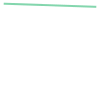

In [110]:
# Create LineString from coordinates
start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
line = LineString([start, end])
line

In [101]:
def make_lines(gdf, df_out, i, elevation = 'ele', time = 'time', geometry = 'geometry'):
    # Get track coordinates
    geom0 = gdf.loc[i][geometry]
    geom1 = gdf.loc[i + 1][geometry]
    
    # Create LineString from coordinates
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    length
    
    # Calculate change in elevation
    elevation_change = gdf.loc[i + 1, elevation] - gdf.loc[i, elevation]
    
    # Calculate time betweent segments
    time_change = pd.to_datetime(gdf.loc[i + 1, time], infer_datetime_format=True) - pd.to_datetime(gdf.loc[i, time], infer_datetime_format=True)
    time_change_seconds = time_change.seconds
    
    # Create a DataFrame to hold record
    data = {'id': i,
            'elevation_change': elevation_change,
            'time_change': time_change_seconds,
            'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'elevation_change', 'time_change','geometry'])
    
    # Add record DataFrame of compiled records
    df_out = pd.concat([df_out, df_line])
    return df_out

In [102]:
# Create an 
df = pd.DataFrame(columns = ['id', 'elevation_change', 'time_change', 'geometry'])

x = 0
while x < len(gdf) - 1:
    df_input = make_lines(gdf, df, x)
    df = df_input
    x = x + 1

df.head()

,id,elevation_change,time_change,geometry
0,0,-0.1,5,"LINESTRING (-78.668663 35.787979, -78.668841 3..."
0,1,-0.2,2,"LINESTRING (-78.668841 35.787985, -78.66897 35..."
0,2,-0.2,2,"LINESTRING (-78.66897 35.788028, -78.669096 35..."
0,3,-0.1,2,"LINESTRING (-78.669096 35.788059, -78.669222 3..."
0,4,-0.1,2,"LINESTRING (-78.669222 35.788086, -78.669372 3..."


In [103]:
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df, crs=crs)

folium.GeoJson(gdf).add_to(m)
m

In [105]:
gdf = gdf.to_crs(epsg = 3857)
gdf['distance_traveled'] = gdf.length
gdf['m_per_sec'] = gdf['distance_traveled'] / gdf['time_change']
gdf = gdf.to_crs(epsg = 4326)
gdf.head()

,id,elevation_change,time_change,geometry,distance_traveled,m_per_sec
0,0,-0.1,5,"LINESTRING (-78.668663 35.78797899999999, -78....",19.831969,3.96639
0,1,-0.2,2,LINESTRING (-78.66884099999997 35.787985000000...,15.525351,7.76268
0,2,-0.2,2,"LINESTRING (-78.66897 35.788028, -78.669096 35...",14.657204,7.3286
0,3,-0.1,2,"LINESTRING (-78.669096 35.78805899999998, -78....",14.507397,7.2537
0,4,-0.1,2,"LINESTRING (-78.66922199999999 35.788086, -78....",17.165622,8.58281


In [43]:
def export_gdf(gdf, filename):
    try:
        os.remove(filename)
    except OSError:
        pass
    gdf.to_file('output.geojson', driver = "GeoJSON")

In [46]:
export_gdf(gdf, 'output.geojson')